In [144]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples, silhouette_score

# listing model 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Cross validation
from HyperclassifierSearch import HyperclassifierSearch

# preprocess 
from sklearn.compose import ColumnTransformer

# Normalize data 
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
import category_encoders as ce

# pipline
from imblearn.pipeline import Pipeline

# dimensional reduction
from sklearn.decomposition import PCA


# Visual the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Import

In [2]:
df = pd.read_csv(filepath_or_buffer='card_data.csv')
df = df.drop(columns='CUST_ID')
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [4]:
df['TENURE'].value_counts()

12    7584
11     365
10     236
6      204
8      196
7      190
9      175
Name: TENURE, dtype: int64

# EDA

In [5]:
df.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

In [6]:
df.skew()

BALANCE                              2.393386
BALANCE_FREQUENCY                   -2.023266
PURCHASES                            8.144269
ONEOFF_PURCHASES                    10.045083
INSTALLMENTS_PURCHASES               7.299120
CASH_ADVANCE                         5.166609
PURCHASES_FREQUENCY                  0.060164
ONEOFF_PURCHASES_FREQUENCY           1.535613
PURCHASES_INSTALLMENTS_FREQUENCY     0.509201
CASH_ADVANCE_FREQUENCY               1.828686
CASH_ADVANCE_TRX                     5.721298
PURCHASES_TRX                        4.630655
CREDIT_LIMIT                         1.522464
PAYMENTS                             5.907620
MINIMUM_PAYMENTS                    13.622797
PRC_FULL_PAYMENT                     1.942820
TENURE                              -2.943017
dtype: float64

In [7]:
df.columns[:-1]

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'],
      dtype='object')

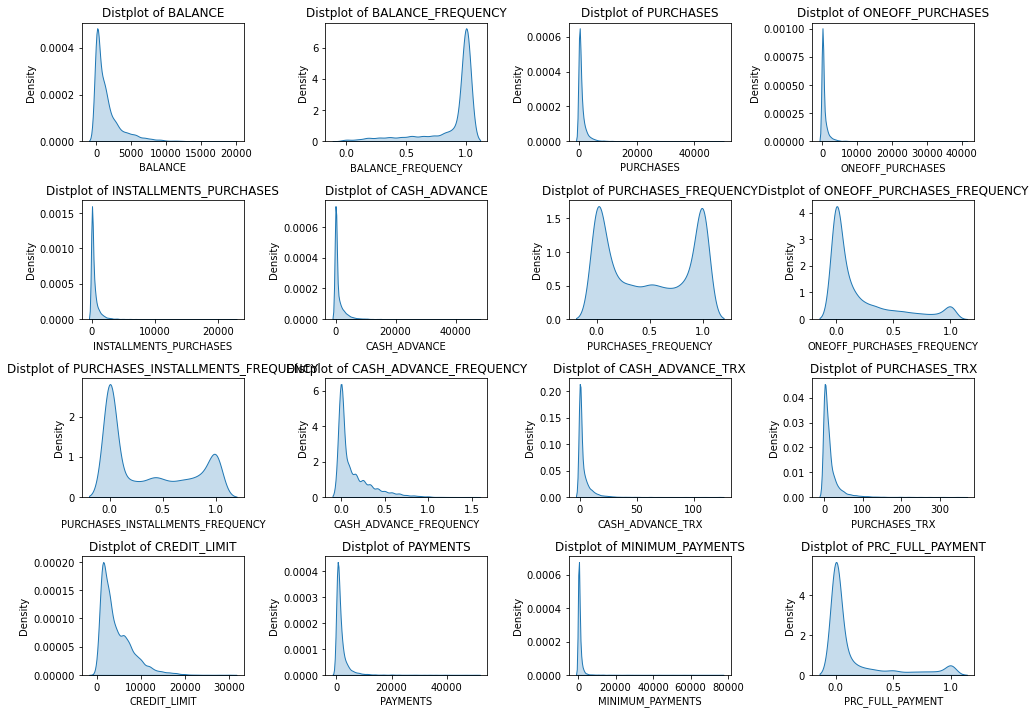

In [8]:
plt.figure(1 , figsize = (16 , 12))
n = 0 
for x in df.columns[:-1]:
    n += 1
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.kdeplot(df[x] ,fill=True)
    plt.title('Distplot of {}'.format(x))
plt.show()

- There is no normal distribution in this dataset => Use Min Max scaler

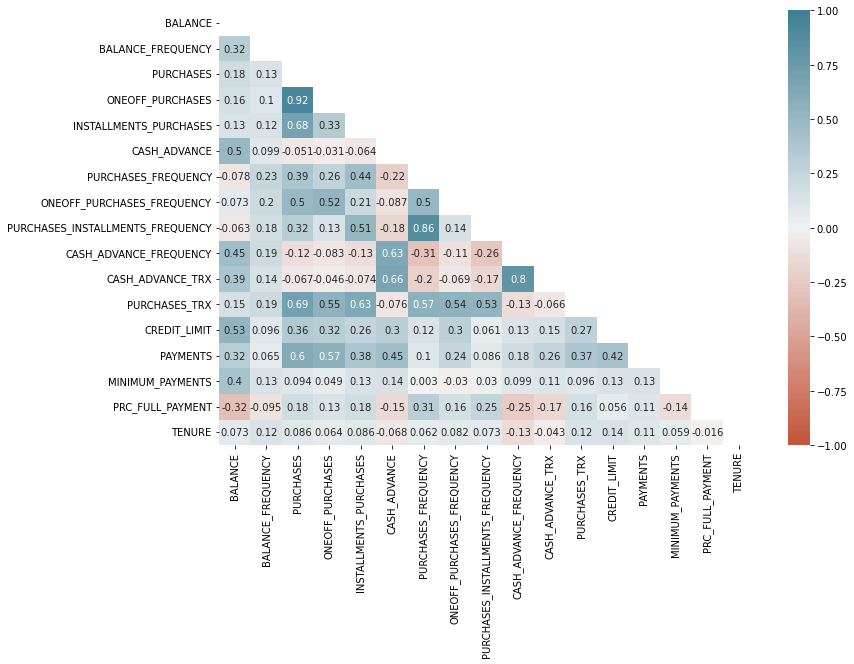

In [9]:
corr = df.corr(numeric_only=True)
mask_ut=np.triu(np.ones(corr.shape)).astype(bool)
plt.figure(figsize=(12,8))
sns.heatmap(corr,
            annot=True,
            vmin=-1,center=0,vmax=1,
            cmap=sns.diverging_palette(20, 220, n=200),
            mask=mask_ut)
plt.show()

In [10]:
# Calculate variance, get 10 largest features
top_ten_var = df.std().sort_values().tail(10)
top_ten_var

CASH_ADVANCE_TRX             6.824647
PURCHASES_TRX               24.857649
INSTALLMENTS_PURCHASES     904.338115
ONEOFF_PURCHASES          1659.887917
BALANCE                   2081.531879
CASH_ADVANCE              2097.163877
PURCHASES                 2136.634782
MINIMUM_PAYMENTS          2372.446607
PAYMENTS                  2895.063757
CREDIT_LIMIT              3638.815725
dtype: float64

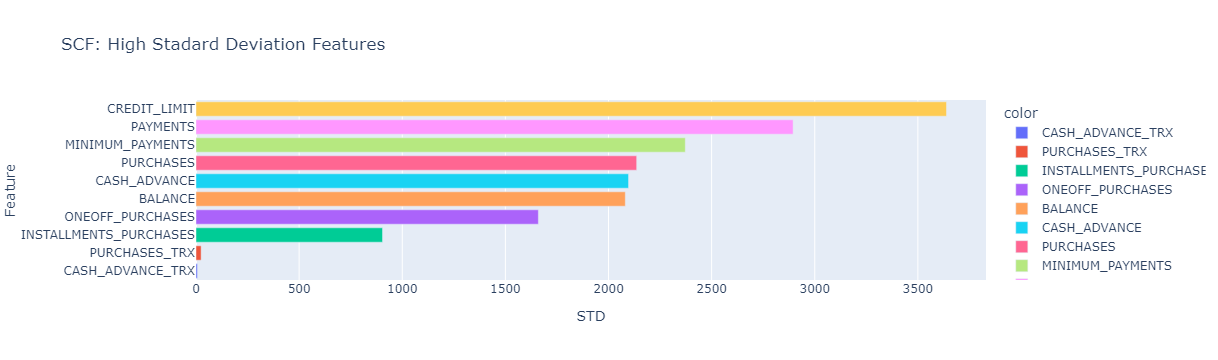

In [11]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    color=top_ten_var.index,
    title="SCF: High Stadard Deviation Features"
)
fig.update_layout(xaxis_title="STD", yaxis_title="Feature")
fig.show()

# Preproccessing Data

- Remove categorical data => help model not bias 

In [179]:
X = df.copy()

In [180]:
# Robust Scaler transformer
mm_scaler = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scaler', MinMaxScaler())
])

tenure_value = np.sort(df['TENURE'].unique())
ord_encoder =  Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', missing_values=np.nan,fill_value=0)),
    ('scaler', OrdinalEncoder(categories=[tenure_value]))
])

# cbe_encoder = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', missing_values=np.nan,fill_value=0)),
#     ('scaler', ce.cat_boost.CatBoostEncoder(handle_missing='value',random_state=42))
# ])


In [181]:
# numeric features and a ordinal feature
num_feature = list(X.columns)
ordinal_feature = list(X.columns[-1:])

# Build preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('ord_features', ord_encoder,ordinal_feature),
        ('min_max_scaler', mm_scaler, num_feature)
    ])

preprocessor.fit(X=X,y=None)

ColumnTransformer(transformers=[('ord_features',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler',
                                                  OrdinalEncoder(categories=[array([ 6,  7,  8,  9, 10, 11, 12])]))]),
                                 ['TENURE']),
                                ('min_max_scaler',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
                                  'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
                                  'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
                                  'ONEOFF_PURCHASES_FREQUENCY',
                                  'PURCHASES_INSTALLMENTS_FREQUENCY',
                                  'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX',
                                  'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
                                  'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
                                  'TENURE'])])

# Build and Evaluate Model

## Params Tuning

In [182]:
def choose_cluster(model, 
                   train_data, 
                   not_gmm:bool=True,is_kmean:bool=False):
    
    n_clusters = range(2,13)
    inertia_errors_list = []
    silhouette_scores_list = []
    
    X_trans = model[:-1].fit_transform(train_data)
    # Add `for` loop to train model and calculate inertia, silhouette score.
    for k in n_clusters:
        # set cn cluster
        if not_gmm:
            model.named_steps['cluster'].n_clusters = k
        else:
            model.named_steps['cluster'].n_components = k
        
        # fit model
        model.fit(train_data)
        
        # Calculate inertia (only apply for Kmeans)
        if is_kmean:
            inertia_errors_list.append(model.named_steps['cluster'].inertia_)
        else:
            inertia_errors_list.append(0)
            
        # Calculate silhouette_scores (apply for 3 model types)
        if not_gmm:
            labels = model.named_steps['cluster'].labels_
        else:
            labels = model.predict(train_data)
    
        silhouette_scores_list.append(silhouette_score(X_trans,labels))
        
    return list(n_clusters), silhouette_scores_list, inertia_errors_list

- KMeans

In [183]:
cluster_km_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_init='auto',init='k-means++',max_iter=200))
])
#cluster_km_model.fit(X)

In [184]:
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))

cluster_list, km_sil_score, km_inertia_errors = choose_cluster(model=cluster_km_model,
                                                               train_data=X,
                                                               not_gmm=True,
                                                               is_kmean=True)
end = time.time()
print(f'Time in running training model: {round((end-start)/60,2)} min')

Start time: Mon May 29 05:17:01 2023
Time in running training model: 0.13 min


In [185]:
km_sil_score

[0.7374617375233483,
 0.3876169178907364,
 0.3938424385954818,
 0.3895645096154748,
 0.3451135893246957,
 0.38884139185415517,
 0.32843597775025885,
 0.3311653186128784,
 0.3518888487622135,
 0.31100310994511127,
 0.2765486521986411]

In [186]:
km_inertia_errors

[7695.872777903701,
 5466.340271990428,
 4191.805489533317,
 3729.685628268185,
 3295.6691716075593,
 3093.2857267156724,
 2893.1661333407883,
 2709.1119061691334,
 2468.844118668968,
 2314.770353499343,
 2178.9854998515116]

- Agglomerative Cluster

In [187]:
cluster_agg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', AgglomerativeClustering(compute_distances=False,
                                        metric='manhattan',
                                        linkage='average'))
])
#cluster_agg_model.fit(X)

In [188]:
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))

cluster_list, ac_sil_score, ac_inertia_errors = choose_cluster(model=cluster_agg_model,
                                                               train_data=X,
                                                               not_gmm=True,
                                                               is_kmean=False)

end = time.time()
print(f'Time in running training model: {round((end-start)/60,2)} min')

Start time: Mon May 29 05:17:09 2023
Time in running training model: 0.47 min


In [189]:
ac_sil_score

[0.3929683102688827,
 0.5541785009941536,
 0.4333823004151111,
 0.34577964401112726,
 0.345121378871563,
 0.25888854882691636,
 0.23254400980428142,
 0.219449510966914,
 0.20190861908667784,
 0.1973982868117183,
 0.20044179475059154]

- GMM

In [190]:
cluster_gmm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', GaussianMixture(random_state=42,
                                max_iter=200,
                                covariance_type='full',
                                init_params='k-means++'))
])
#cluster_gmm_model.fit(X)

In [191]:
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))

cluster_list, gmm_sil_score, gmm_inertia_errors = choose_cluster(model=cluster_gmm_model,
                                                               train_data=X,
                                                               not_gmm=False,
                                                               is_kmean=False)

end = time.time()
print(f'Time in running training model: {round((end-start)/60,2)} min')

Start time: Mon May 29 05:17:37 2023
Time in running training model: 0.18 min


In [192]:
gmm_sil_score

[0.03242693428365155,
 0.1322890526205551,
 0.03475037185004316,
 0.019828888835436456,
 0.04473330704990639,
 0.033988277259826144,
 0.012331022459253146,
 0.008322025695013245,
 -0.025110293267650213,
 -0.0028947573585881166,
 0.026641740535381722]

## Evaluating model:

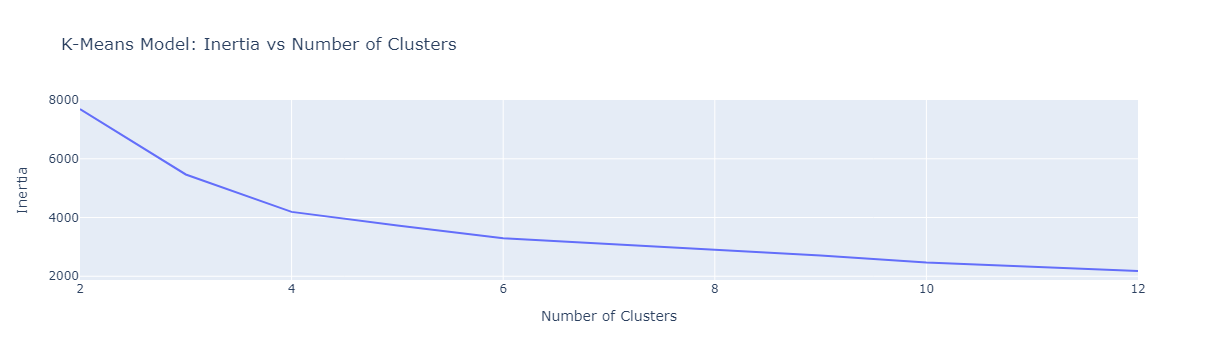

In [193]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=cluster_list, y=km_inertia_errors,title='K-Means Model: Inertia vs Number of Clusters'
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

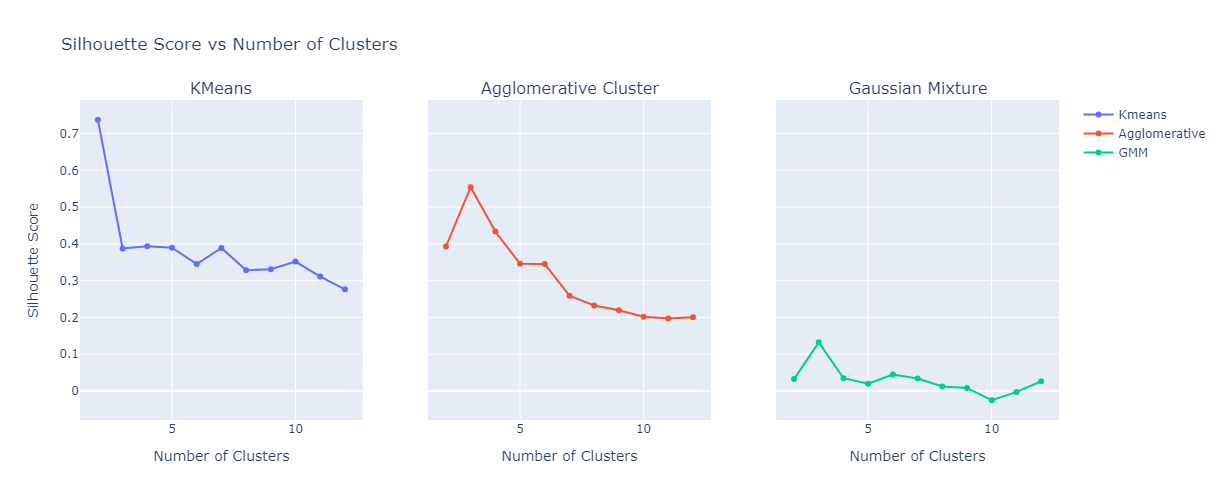

In [194]:
fig = make_subplots(rows=1, 
                    cols=3,
                    subplot_titles=("KMeans", "Agglomerative Cluster", "Gaussian Mixture"),
                    shared_yaxes=True
                   )

fig.add_trace(
    go.Scatter(x=cluster_list, y=km_sil_score, name="Kmeans"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=cluster_list, y=ac_sil_score,name="Agglomerative"),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=cluster_list, y=gmm_sil_score,name="GMM"),
    row=1, col=3
)

# Update xaxis properties
fig.update_xaxes(title_text="Number of Clusters",row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=3)


fig.update_layout(height=500, width=1200, title_text="Silhouette Score vs Number of Clusters",
                  yaxis_title="Silhouette Score")
fig.show()

- As can be seen from the above plots, we could use n_cluster = 2 of Kmeans or n_cluster = 3 of Agglomerative cluster

# PCA:

## first model

In [209]:
# Instantiate transformer
X_new = X.drop(columns='TENURE')
num_feature = list(X_new.columns)
# preprocesser 
preprocessor = ColumnTransformer(
    transformers=[
        ('min_max_scaler', mm_scaler, num_feature)
    ])

# build model
cluster_final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    #('cluster', KMeans(n_init='auto',init='k-means++',max_iter=200,n_clusters=2)),
    ('cluster', AgglomerativeClustering(compute_distances=False,
                                        n_clusters=3,
                                        metric='manhattan',
                                        linkage='average'))
])


cluster_final_model.fit(X=X_new)
# Transform `X`
X_t = cluster_final_model[:-1].transform(X_new)

# Get label from model
labels = cluster_final_model.named_steps['cluster'].labels_

# Put `X_t` into DataFrame
std_sclaler = StandardScaler()
X_t_sclaler = std_sclaler.fit_transform(X_t)
X_pca = pd.DataFrame(X_t_sclaler, columns=['PC1','PC2'])

#print("Inertia score",cluster_final_model.named_steps['cluster'].inertia_)
print("Silhouette score",silhouette_score(X_t,labels))
print("X_pca shape:", X_pca.shape)
X_pca.head()

Silhouette score 0.5534204867406428
X_pca shape: (8950, 2)


PC1       PC2
0 -0.846886 -0.364488
1 -1.067705 -0.090431
2  0.525451  3.020850
3 -1.032784 -0.047284
4 -0.973280  0.120826

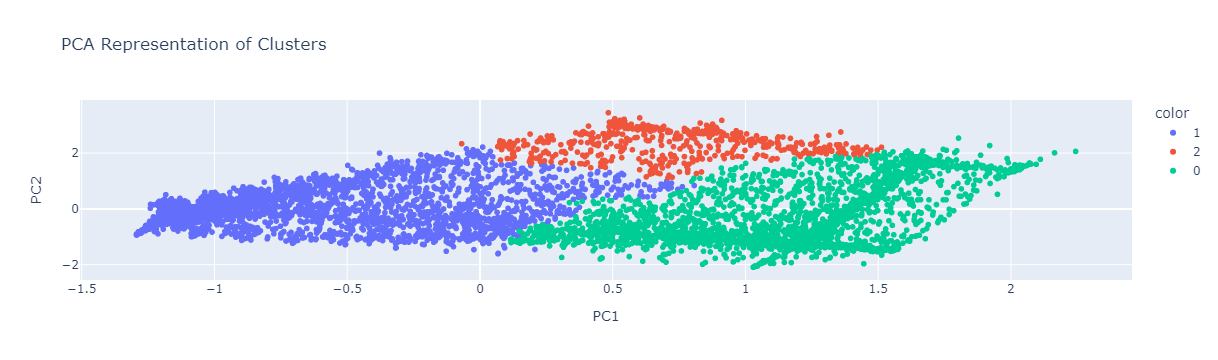

In [210]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(data_frame=X_pca,
                 x='PC1',
                 y='PC2',
                 color=labels.astype(str),
                 title="PCA Representation of Clusters",
                )

fig.update_layout(xaxis_title='PC1',yaxis_title='PC2')

fig.show()

## Second model

In [211]:
# Instantiate transformer
X_new = X.drop(columns='TENURE')
num_feature = list(X_new.columns)
# preprocesser 
preprocessor = ColumnTransformer(
    transformers=[
        ('min_max_scaler', mm_scaler, num_feature)
    ])

# build model
cluster_final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('cluster', KMeans(n_init='auto',init='k-means++',max_iter=200,n_clusters=2)),
])


cluster_final_model.fit(X=X_new)
# Transform `X`
X_t = cluster_final_model[:-1].transform(X_new)

# Get label from model
labels = cluster_final_model.named_steps['cluster'].labels_

# Put `X_t` into DataFrame
std_sclaler = StandardScaler()
X_t_sclaler = std_sclaler.fit_transform(X_t)
X_pca = pd.DataFrame(X_t_sclaler, columns=['PC1','PC2'])

print("Inertia score",cluster_final_model.named_steps['cluster'].inertia_)
print("Silhouette score",silhouette_score(X_t,labels))
print("X_pca shape:", X_pca.shape)
X_pca.head()

Inertia score 1346.0864650893475
Silhouette score 0.5802829915277948
X_pca shape: (8950, 2)


PC1       PC2
0 -0.846886 -0.364488
1 -1.067705 -0.090431
2  0.525451  3.020850
3 -1.032784 -0.047284
4 -0.973280  0.120826

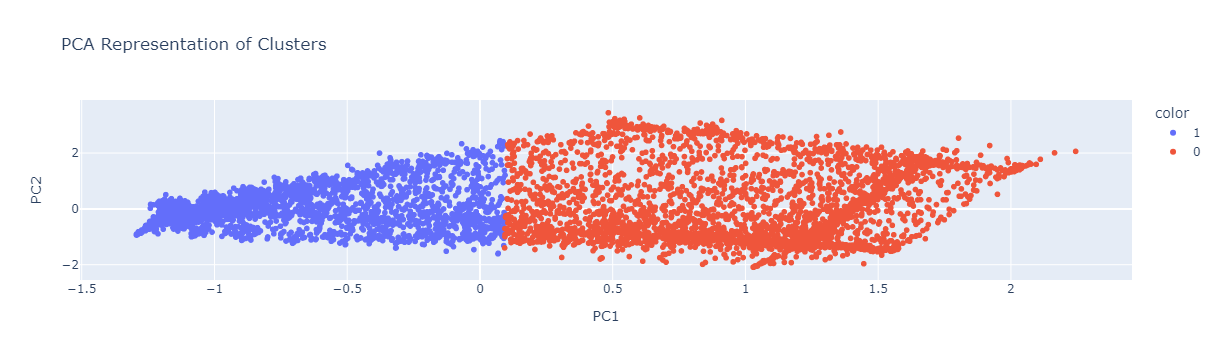

In [212]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(data_frame=X_pca,
                 x='PC1',
                 y='PC2',
                 color=labels.astype(str),
                 title="PCA Representation of Clusters",
                )

fig.update_layout(xaxis_title='PC1',yaxis_title='PC2')

fig.show()